In [12]:
from pathlib import Path
import shutil
import random
from typing import List
import yaml

from ultralytics.models import YOLO
import torch
from IPython.display import Image as IPImage, display

In [2]:
# Configuration
TXT_PATH = Path("txt_output_folder")
IMG_PATH = Path("balls")
DATASET_ROOT = Path("yolo_dataset")

# Split ratio
TRAIN_RATIO = 0.8

# Device configuration
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Seed for reproducibility
random.seed(42)

print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

print(f"\nTXT files: {len(list(TXT_PATH.glob('*.txt')))}")
print(f"Images: {len([p for p in IMG_PATH.glob('*') if p.suffix.lower() in ['.jpg', '.jpeg', '.png']])}")

Device: cuda:0
GPU: NVIDIA GeForce RTX 3080 Laptop GPU
CUDA version: 12.8

TXT files: 709
Images: 709


In [5]:
# Créer la structure de dataset YOLO
def create_yolo_structure():
    """Crée la structure de dossiers pour YOLO"""
    dirs = [
        DATASET_ROOT / "train" / "images",
        DATASET_ROOT / "train" / "labels",
        DATASET_ROOT / "val" / "images",
        DATASET_ROOT / "val" / "labels"
    ]
    
    for d in dirs:
        d.mkdir(parents=True, exist_ok=True)
    
    print(f"✓ Structure créée dans {DATASET_ROOT}")

create_yolo_structure()

✓ Structure créée dans yolo_dataset


In [6]:
# Split et copie des fichiers
def split_and_copy_data():
    """Split les données 80/20 et les copie dans la structure YOLO"""
    # Récupérer tous les fichiers txt
    txt_files = list(TXT_PATH.glob("*.txt"))
    
    # Trouver les images correspondantes
    data_pairs = []
    for txt_file in txt_files:
        # Chercher l'image correspondante (même stem)
        stem = txt_file.stem
        img_file = None
        for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']:
            candidate = IMG_PATH / f"{stem}{ext}"
            if candidate.exists():
                img_file = candidate
                break
        
        if img_file:
            data_pairs.append((img_file, txt_file))
    
    print(f"Paires trouvées: {len(data_pairs)}")
    
    # Shuffle
    random.shuffle(data_pairs)
    
    # Split
    split_idx = int(len(data_pairs) * TRAIN_RATIO)
    train_pairs = data_pairs[:split_idx]
    val_pairs = data_pairs[split_idx:]
    
    print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}")
    
    # Copier les fichiers
    for img_file, txt_file in train_pairs:
        shutil.copy(img_file, DATASET_ROOT / "train" / "images" / img_file.name)
        shutil.copy(txt_file, DATASET_ROOT / "train" / "labels" / txt_file.name)
    
    for img_file, txt_file in val_pairs:
        shutil.copy(img_file, DATASET_ROOT / "val" / "images" / img_file.name)
        shutil.copy(txt_file, DATASET_ROOT / "val" / "labels" / txt_file.name)
    
    print("✓ Données copiées")
    return len(train_pairs), len(val_pairs)

train_count, val_count = split_and_copy_data()

Paires trouvées: 709
Train: 567, Val: 142
✓ Données copiées
✓ Données copiées


In [3]:
# Créer le fichier data.yaml pour YOLO
def create_data_yaml():
    """Crée le fichier de configuration du dataset"""
    data = {
        'path': str(DATASET_ROOT.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'nc': 2,  # 2 classes: ball et person
        'names': {
            0: 'ball',
            1: 'person'
        }
    }
    
    yaml_path = DATASET_ROOT / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f, default_flow_style=False)
    
    print(f"✓ Fichier data.yaml créé: {yaml_path}")
    return yaml_path

yaml_path = create_data_yaml()
print(f"\nContenu de data.yaml:")
print(open(yaml_path).read())

✓ Fichier data.yaml créé: yolo_dataset/data.yaml

Contenu de data.yaml:
names:
  0: ball
  1: person
nc: 2
path: /home/tonino/projects/ball segmentation/yolo_dataset
train: train/images
val: val/images



In [ ]:
model = YOLO('yolo11n-seg.pt')

# Déplacer le modèle sur le bon device
if DEVICE != 'cpu':
    model.to(DEVICE)

print(f"✓ Modèle YOLOv11n-seg chargé sur {DEVICE}")

✓ Modèle YOLOv11n-seg chargé sur cuda:0


: 

In [ ]:
# Fine-tuning
# Note: Le modèle COCO a 80 classes incluant 'person' (classe 0)
# Nous redéfinissons seulement 2 classes: ball (0) et person (1)
# Le modèle conservera les poids pré-entraînés pour person

results = model.train(
    data=str(yaml_path),
    epochs=5,
    imgsz=640,
    batch=16,
    device=DEVICE,
    project='runs/segment',
    name='yolo11n_ball_person',
    exist_ok=True,
    pretrained=True,  # Partir des poids COCO
    optimizer='Adam',
    lr0=0.001,
    patience=10,  # Early stopping
    save=True,
    save_period=10,
    plots=True,  # Génère des graphiques
    workers=0,  # Évite les problèmes de multiprocessing dans Jupyter
    val=False,  # Désactive la validation automatique finale (on la fera manuellement)
    
    # # Augmentation
    # hsv_h=0.015,
    # hsv_s=0.7,
    # hsv_v=0.4,
    # degrees=10.0,
    # translate=0.1,
    # scale=0.5,
    # flipud=0.0,
    # fliplr=0.5,
    # mosaic=1.0
)

print("\n✅ Entraînement terminé! Exécutez la cellule suivante pour valider le modèle.")



Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_ball_person, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, per

## ⚠️ Note sur le blocage de validation

Si la validation finale bloque à 60%, c'est un bug connu d'Ultralytics. L'entraînement s'est bien terminé (5 epochs en ~4 minutes). 

**Solution:** Interrompre la cellule (bouton Stop) et exécuter la cellule suivante pour valider manuellement le meilleur modèle.

In [4]:
# Charger le meilleur modèle et valider
print("\n" + "="*50)
print("VALIDATION DU MEILLEUR MODÈLE")
print("="*50)

# Charger le meilleur modèle entraîné
best_model_path = Path('runs/segment/yolo11n_ball_person/weights/best.pt')
if best_model_path.exists():
    print(f"\n✓ Chargement du meilleur modèle: {best_model_path}")
    best_model = YOLO(str(best_model_path))
    
    # Validation avec workers=0 pour éviter les blocages
    print("\n🔄 Validation en cours...")
    metrics = best_model.val(
        data=str(yaml_path),
        batch=8,  # Batch plus petit pour la validation
        workers=0,  # Évite les problèmes de multiprocessing
        device=DEVICE
    )
    
    print(f"\n✅ Métriques de segmentation:")
    print(f"  - mAP50 (box): {metrics.box.map50:.4f}")
    print(f"  - mAP50-95 (box): {metrics.box.map:.4f}")
    print(f"  - mAP50 (mask): {metrics.seg.map50:.4f}")
    print(f"  - mAP50-95 (mask): {metrics.seg.map:.4f}")
    
    print(f"\n📊 Par classe:")
    for i, name in enumerate(['ball', 'person']):
        if i < len(metrics.seg.ap50):
            print(f"  - {name}: mAP50={metrics.seg.ap50[i]:.4f}, mAP50-95={metrics.seg.ap[i]:.4f}")
else:
    print(f"⚠️ Modèle non trouvé: {best_model_path}")


VALIDATION DU MEILLEUR MODÈLE

✓ Chargement du meilleur modèle: runs/segment/yolo11n_ball_person/weights/best.pt

🔄 Validation en cours...

🔄 Validation en cours...
Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
Ultralytics 8.3.235 🚀 Python-3.12.10 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 9.6 GFLOPs
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 87.5±84.3 MB/s, size: 267.9 KB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 87.5±84.3 MB/s, size: 267.9 KB)
val: Scanning /home/tonino/projects/ball segmentation/yolo_dataset/val/labels.cache... 142 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 142/142 78.3Kit/s 0.0s
val: /home/tonino/projects/ball segmentation/yolo_dataset/val/images/20251201_195730.jpg: corrupt JPEG restored an

## Résumé

Ce notebook a:
1. Créé un dataset YOLO avec split 80/20
2. Fine-tuné YOLOv11n-seg sur 2 classes:
   - **ball** (classe 0): nos nouvelles annotations
   - **person** (classe 1): conserve les poids pré-entraînés COCO
3. Évalué les performances avec métriques mAP50 et mAP50-95
4. Généré des visualisations (courbes, matrice de confusion, prédictions)

Le modèle final est sauvegardé dans `runs/segment/yolo11n_ball_person/weights/best.pt`

In [6]:
model = best_model

In [9]:
from PIL import Image

Test sur: IMG_2345_JPG.rf.89cfcd44782782b2dcaa161f30bd0f52.jpg

image 1/1 /home/tonino/projects/ball segmentation/yolo_dataset/val/images/IMG_2345_JPG.rf.89cfcd44782782b2dcaa161f30bd0f52.jpg: 640x640 1 ball, 49.1ms
Speed: 3.8ms preprocess, 49.1ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/test_predictions
image 1/1 /home/tonino/projects/ball segmentation/yolo_dataset/val/images/IMG_2345_JPG.rf.89cfcd44782782b2dcaa161f30bd0f52.jpg: 640x640 1 ball, 49.1ms
Speed: 3.8ms preprocess, 49.1ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/test_predictions


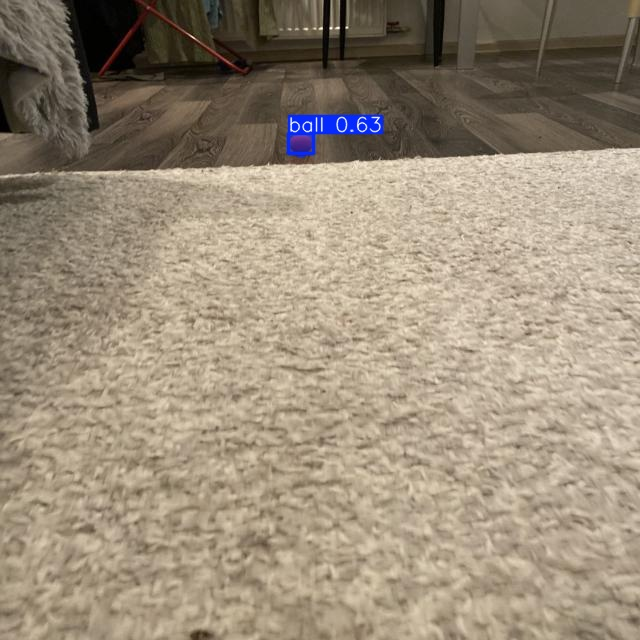


Détections:
  - ball: confidence=0.63


In [18]:
# Tester sur une image
test_img = list(DATASET_ROOT.glob("val/images/*.jpg"))[-1]
print(f"Test sur: {test_img.name}")

# Prédiction
results = model.predict(
    source=str(test_img),
    save=True,
    conf=0.25,
    iou=0.7,
    device=DEVICE,
    show_labels=True,
    show_conf=True,
    project='runs/segment',
    name='test_predictions',
    exist_ok=True
)

# Afficher le résultat
pred_path = Path('runs/segment/test_predictions') / test_img.name
if pred_path.exists():
    display(IPImage(filename=str(pred_path), width=800))

# Afficher les détections
for r in results:
    if r.masks is not None:
        print(f"\nDétections:")
        for i, (box, cls) in enumerate(zip(r.boxes.xyxy, r.boxes.cls)):
            class_name = 'ball' if int(cls) == 0 else 'person'
            conf = r.boxes.conf[i]
            print(f"  - {class_name}: confidence={conf:.2f}")

TEST DE DÉTECTION DES HUMAINS

Test sur: 20251201_200005.jpg



image 1/1 /home/tonino/projects/ball segmentation/yolo_dataset/human val/20251201_200005.jpg: 640x480 1 ball, 216.1ms
Speed: 6.1ms preprocess, 216.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/human_detection_test
Speed: 6.1ms preprocess, 216.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /home/tonino/projects/ball segmentation/runs/segment/human_detection_test

📊 Détections trouvées: 1
  - ball: confidence=0.89

📈 Résumé: 1 ball(s), 0 person(s)

🖼️ Image avec prédictions:

📊 Détections trouvées: 1
  - ball: confidence=0.89

📈 Résumé: 1 ball(s), 0 person(s)

🖼️ Image avec prédictions:


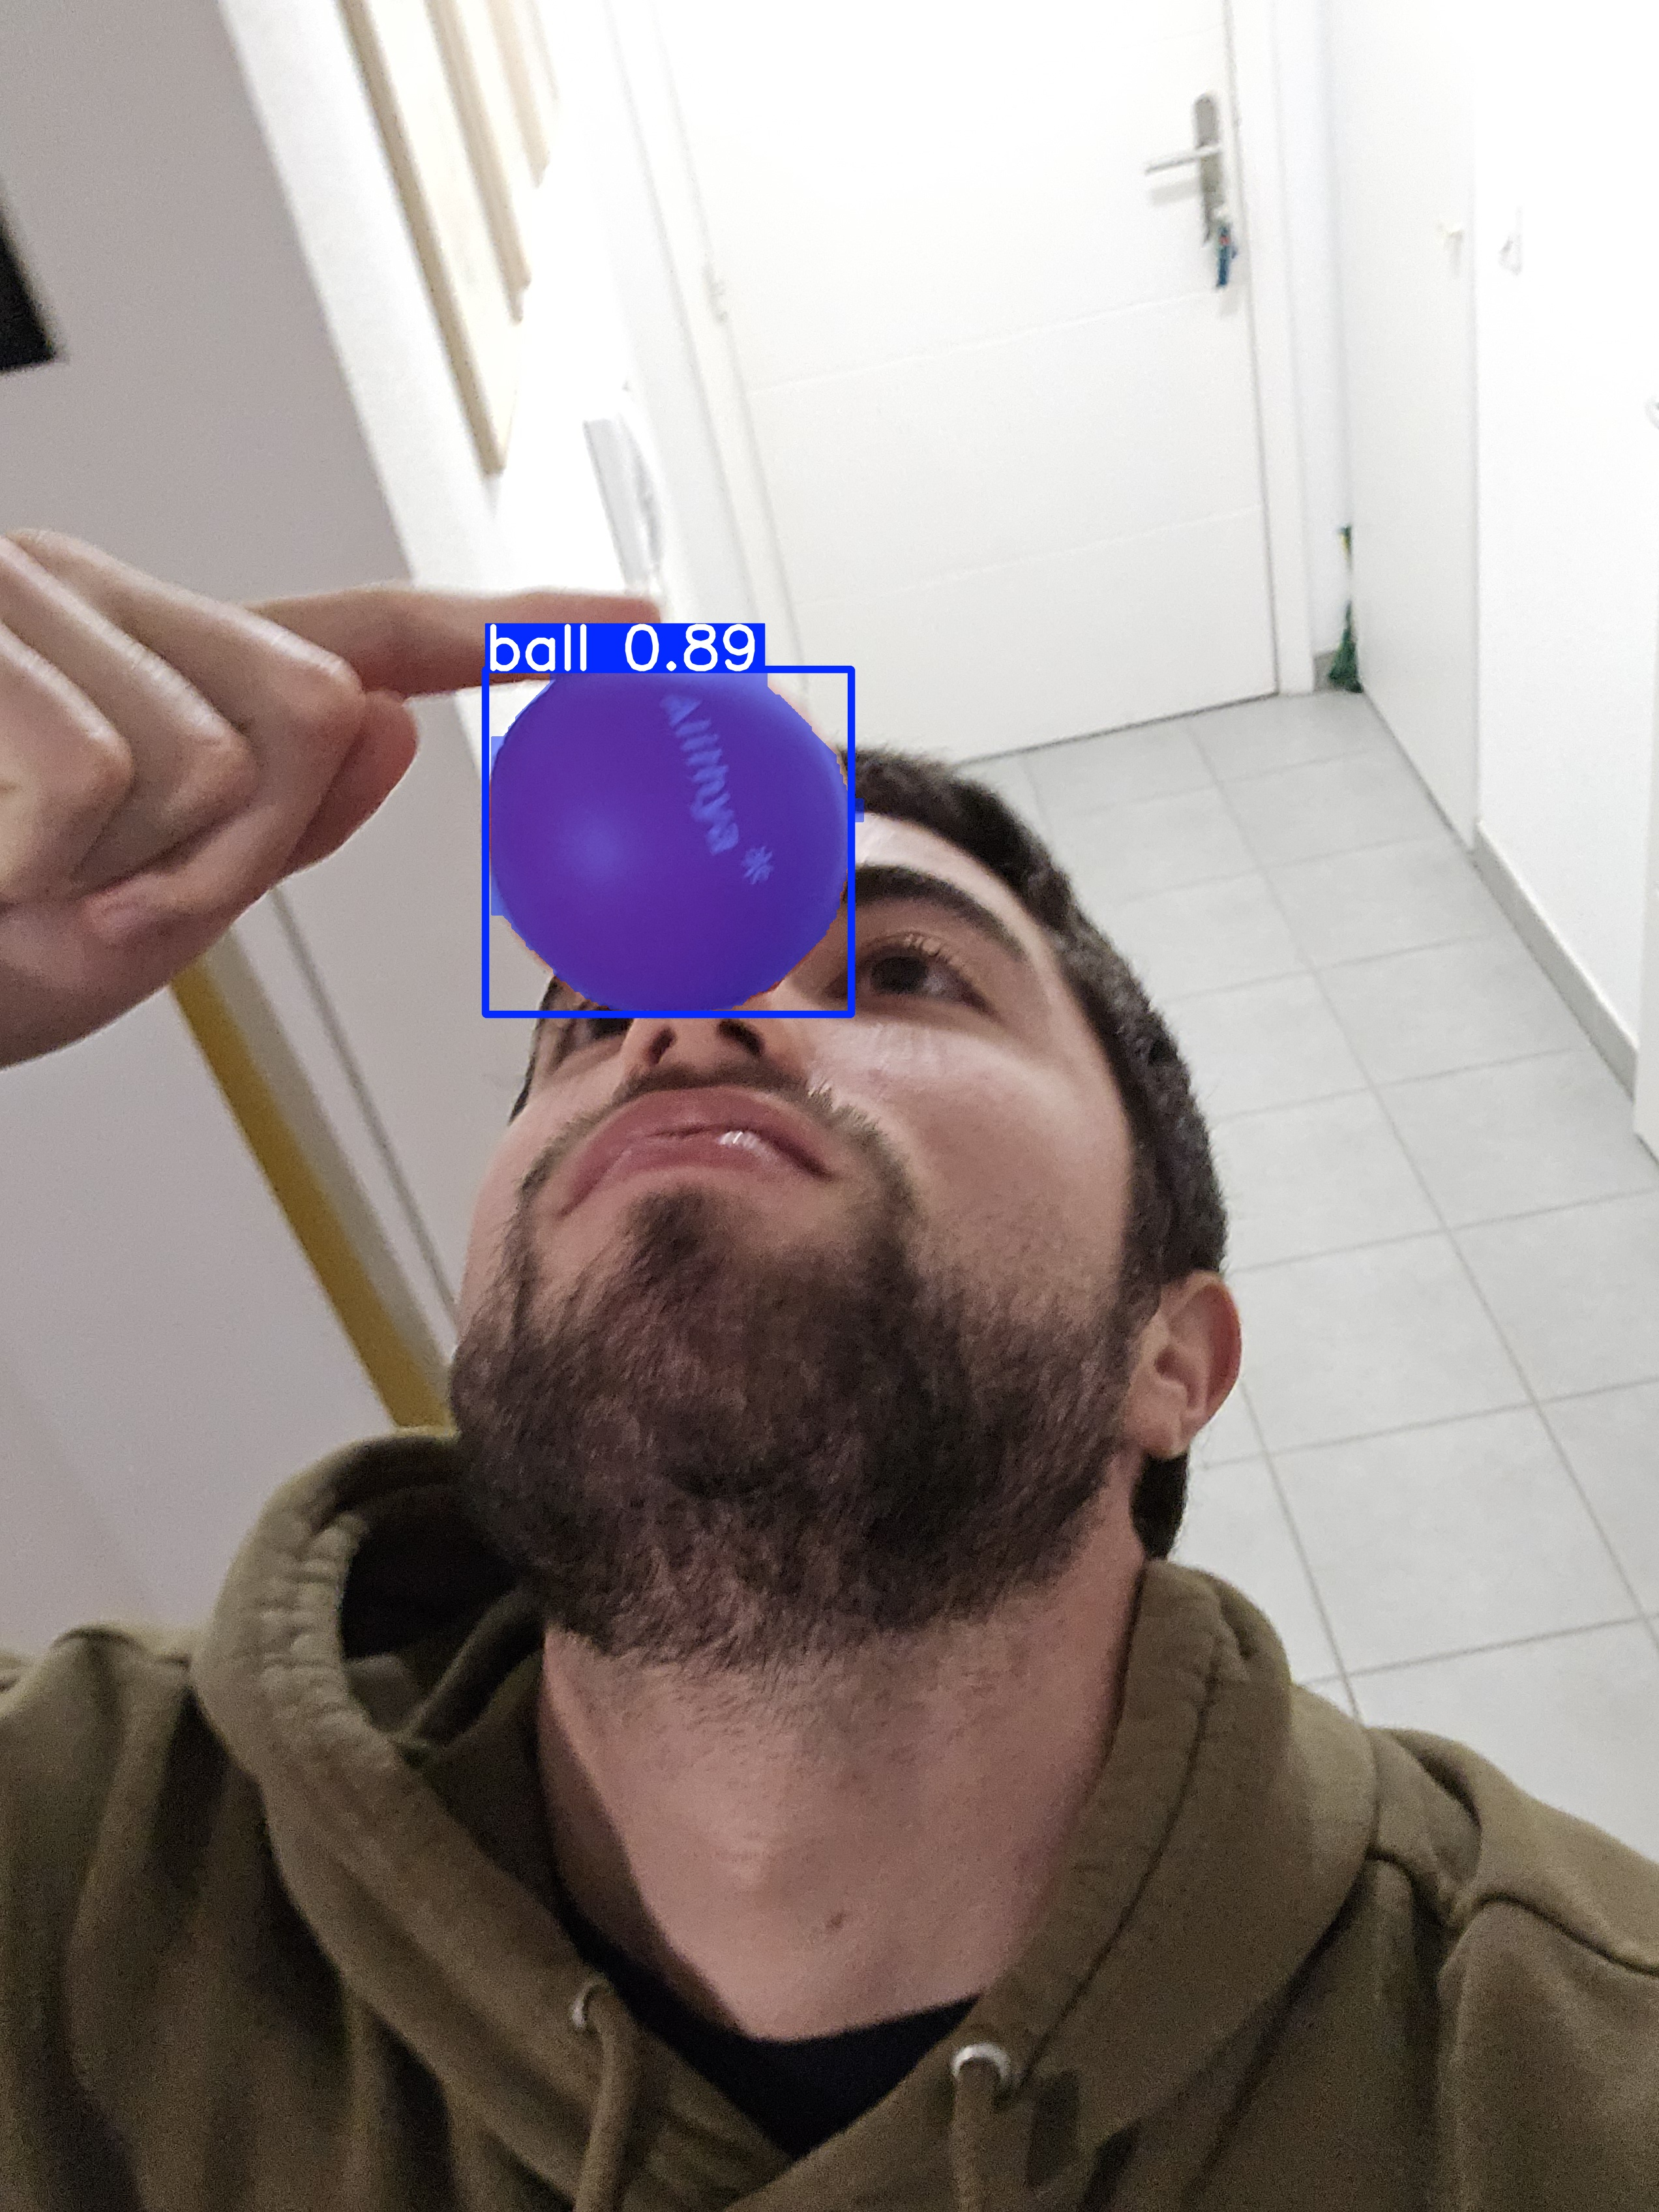


✅ Test terminé!


In [22]:
# Tester la détection des humains sur plusieurs images
print("="*50)
print("TEST DE DÉTECTION DES HUMAINS")
print("="*50)

# Tester sur plusieurs images du validation set
val_images = list(DATASET_ROOT.glob("human val/*.jpg"))[0:]  # Prendre 5 images

for test_img in val_images:
    print(f"\n{'='*50}")
    print(f"Test sur: {test_img.name}")
    
    # Prédiction
    results = model.predict(
        source=str(test_img),
        save=True,
        conf=0.25,
        iou=0.7,
        device=DEVICE,
        show_labels=True,
        show_conf=True,
        project='runs/segment',
        name='human_detection_test',
        exist_ok=True
    )
    
    # Analyser les détections
    for r in results:
        if r.boxes is not None and len(r.boxes) > 0:
            print(f"\n📊 Détections trouvées: {len(r.boxes)}")
            
            # Compter par classe
            ball_count = 0
            person_count = 0
            
            for i, (box, cls) in enumerate(zip(r.boxes.xyxy, r.boxes.cls)):
                class_id = int(cls)
                class_name = 'ball' if class_id == 0 else 'person'
                conf = r.boxes.conf[i]
                
                if class_id == 0:
                    ball_count += 1
                else:
                    person_count += 1
                    
                print(f"  - {class_name}: confidence={conf:.2f}")
            
            print(f"\n📈 Résumé: {ball_count} ball(s), {person_count} person(s)")
        else:
            print("⚠️ Aucune détection")
    
    # Afficher l'image prédite
    pred_path = Path('runs/segment/human_detection_test') / test_img.name
    if pred_path.exists():
        print(f"\n🖼️ Image avec prédictions:")
        display(IPImage(filename=str(pred_path), width=600))

print(f"\n{'='*50}")
print("✅ Test terminé!")


Graphiques d'entraînement:
⚠ results.png non trouvé
⚠ confusion_matrix.png non trouvé

val_batch0_labels.jpg:


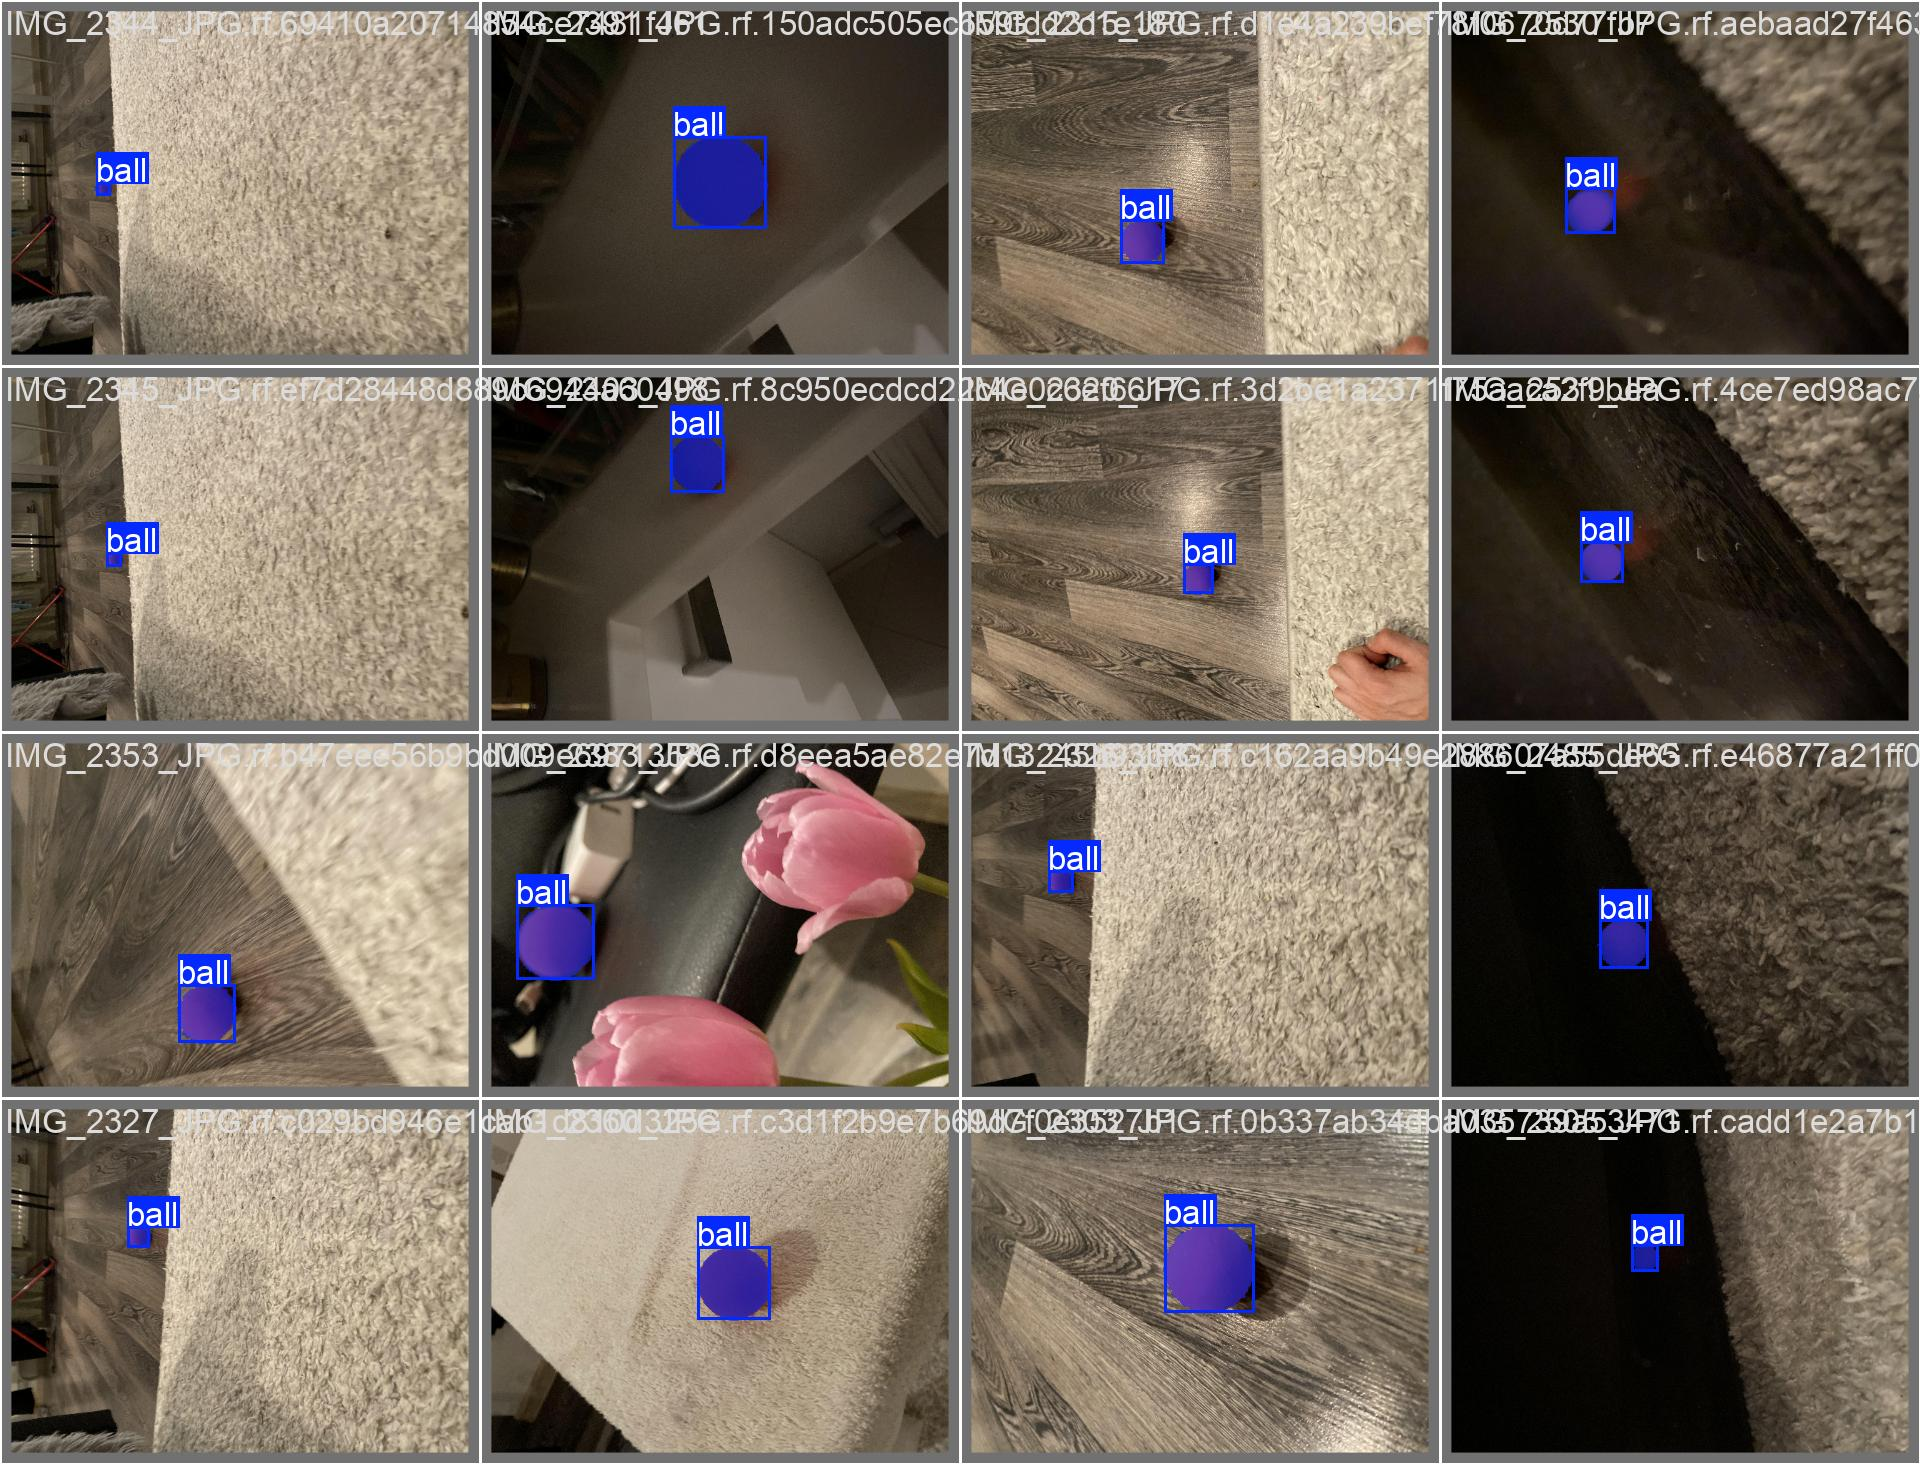


val_batch0_pred.jpg:


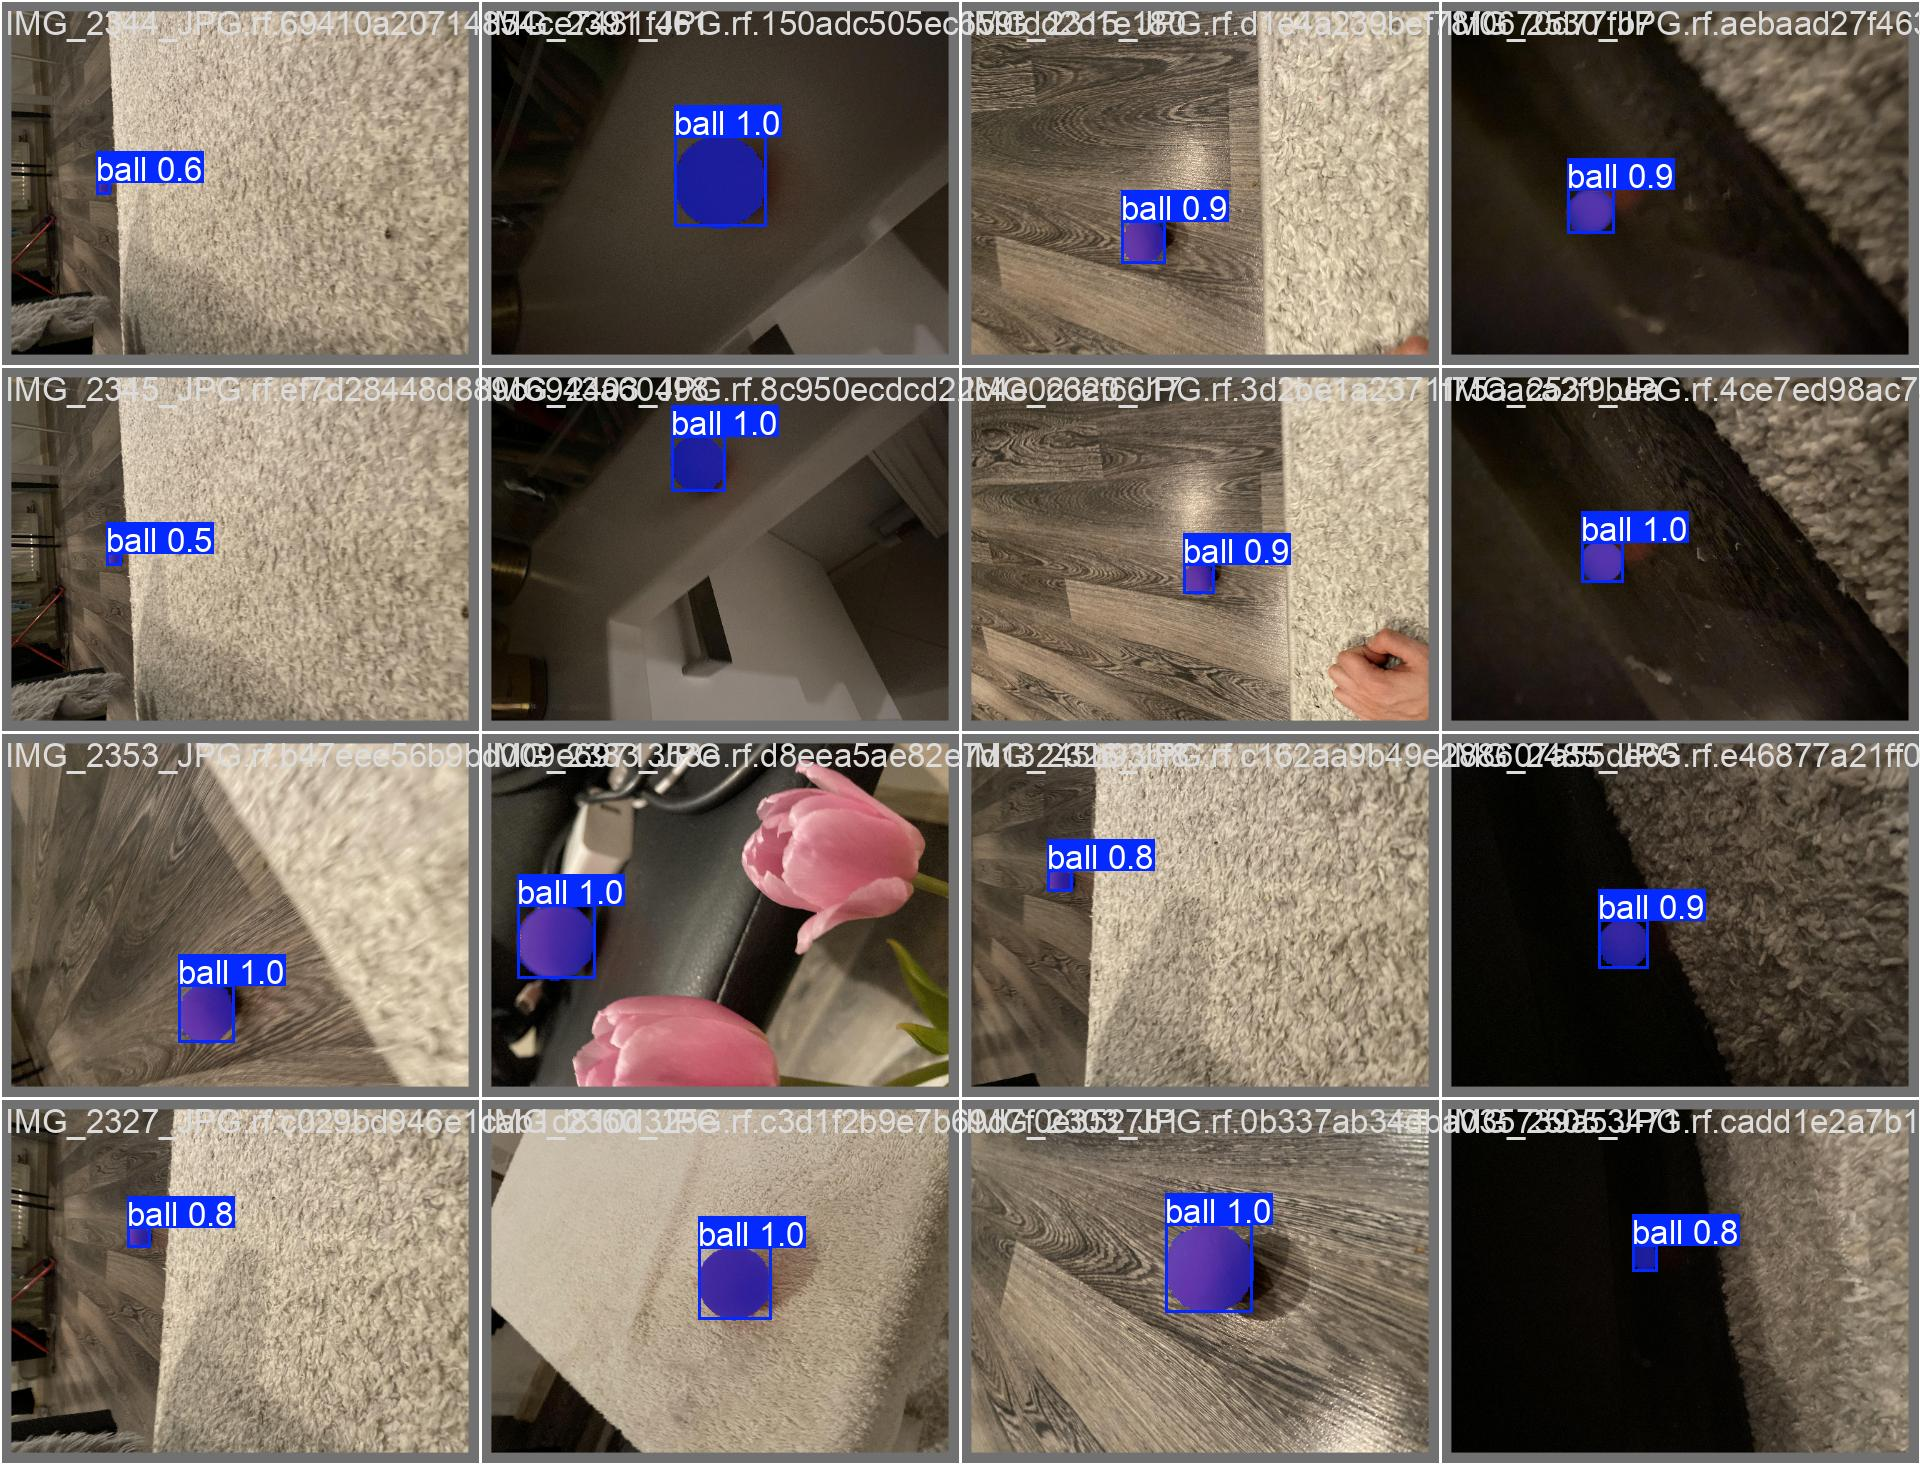

In [19]:
# Visualiser les résultats
import os

# Trouver le dossier de résultats
results_dir = Path('runs/segment/yolo11n_ball_person')

if results_dir.exists():
    print("\nGraphiques d'entraînement:")
    
    # Courbes d'entraînement
    plots = ['results.png', 'confusion_matrix.png', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg']
    
    for plot in plots:
        plot_path = results_dir / plot
        if plot_path.exists():
            print(f"\n{plot}:")
            display(IPImage(filename=str(plot_path), width=800))
        else:
            print(f"⚠ {plot} non trouvé")
else:
    print(f"⚠ Dossier de résultats non trouvé: {results_dir}")